In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Where Are Real Galaxies?

Real galaxies would ideally be distributed evenly throughout the hypercube. If they are clustered in one pocket, our cube is over too large a range of real parameters and we're wasting cube-points teaching the emulator about the photometry of parameter values that no real galaxy has.

Happily, it looks like the galaxies are fairly well spread. We can also 

In [2]:
import os

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')
import corner
from tqdm.auto import tqdm  # notebook friendly
import glob
from agnfinder.prospector.main import load_catalog
from agnfinder.prospector import load_photometry
from agnfinder import simulation_samples, simulation_utils

In [3]:
os.chdir('/home/walml/repos/agnfinder')

In [4]:
catalog_loc = '/media/walml/beta/agnfinder/cpz_paper_sample_week3.parquet'
catalog = load_catalog(catalog_loc)

In [5]:
os.chdir('/home/walml/repos/agnfinder')
grid_loc = 'data/photometry_simulation_100000.hdf5'

In [6]:
def load_grid(grid_loc):
    assert os.path.isfile(grid_loc)
    with h5py.File(grid_loc, 'r') as f:
        param_names = f['samples']['theta'].attrs['columns']  # stored as "attribute" metadata
        norm_theta = f['samples']['normalised_theta'][...]
        theta = f['samples']['theta'][...]
        simulated_y = f['samples']['simulated_y'][...]
        wavelengths = f['samples']['wavelengths'][...]
    return param_names, norm_theta, theta, simulated_y, wavelengths

In [7]:
cube_dir = 'data/cubes/euclid_med'

In [8]:
grid_locs = glob.glob(f'{cube_dir}/*.hdf5')
assert grid_locs

norm_theta_list = []
theta_list = []
simulated_y_list = []
wavelengths_list = []

for grid_loc in grid_locs:
    param_names, norm_theta, theta, simulated_y, wavelengths = load_grid(grid_loc)
    norm_theta_list.append(norm_theta)
    theta_list.append(theta)
    simulated_y_list.append(simulated_y)
    wavelengths_list.append(wavelengths)

In [71]:
simulated_y = np.concatenate(simulated_y_list)
norm_theta = np.concatenate(norm_theta_list)
theta = np.concatenate(theta_list)
wavelengths = np.concatenate(wavelengths_list)

In [70]:
simulated_y.shape

(600000, 8)

In [37]:
output_dim = 9  
# output_dim = 8
# output_dim = 7
n_galaxies = 5000

In [38]:
# best_thetas = np.zeros((n_galaxies, output_dim))
# best_norm_theta = np.zeros((n_galaxies, output_dim))
# for n in range(n_galaxies):  # could probably do in one go if this is slow
#     _, photometry, _ = load_photometry.load_maggies_from_galaxy(catalog.sample().squeeze(), reliable=True)
#     error = np.sum((photometry - simulated_y) ** 2, axis=1)
#     best_params_index = np.argmin(error) # equivalent to an MLE in discrete space
#     best_thetas[n] = theta[best_params_index]
#     best_norm_theta[n] = norm_theta[best_params_index]


In [39]:
from sedpy import observate

In [40]:
from agnfinder.prospector.load_photometry import Filter

In [41]:
# valid_filters = [Filter(bandpass_file='u_sloan', mag_col='mag_auto_sdss_u_dr12', error_col='magerr_auto_sdss_u_dr12'), Filter(bandpass_file='g_sloan', mag_col='mag_auto_sdss_g_dr12', error_col='magerr_auto_sdss_g_dr12'), Filter(bandpass_file='r_sloan', mag_col='mag_auto_sdss_r_dr12', error_col='magerr_auto_sdss_r_dr12'), Filter(bandpass_file='i_sloan', mag_col='mag_auto_sdss_i_dr12', error_col='magerr_auto_sdss_i_dr12'), Filter(bandpass_file='z_sloan', mag_col='mag_auto_sdss_z_dr12', error_col='magerr_auto_sdss_z_dr12'), Filter(bandpass_file='VISTA_H', mag_col='mag_auto_viking_h_dr2', error_col='magerr_auto_viking_h_dr2'), Filter(bandpass_file='VISTA_J', mag_col='mag_auto_viking_j_dr2', error_col='magerr_auto_viking_j_dr2'), Filter(bandpass_file='VISTA_Ks', mag_col='mag_auto_viking_k_dr2', error_col='magerr_auto_viking_k_dr2'), Filter(bandpass_file='VISTA_Y', mag_col='mag_auto_viking_y_dr2', error_col='magerr_auto_viking_y_dr2'), Filter(bandpass_file='VISTA_Z', mag_col='mag_auto_viking_z_dr2', error_col='magerr_auto_viking_z_dr2'), Filter(bandpass_file='wise_w1', mag_col='mag_auto_AllWISE_W1', error_col='magerr_auto_AllWISE_W1'), Filter(bandpass_file='wise_w2', mag_col='mag_auto_AllWISE_W2', error_col='magerr_auto_AllWISE_W2')]
valid_filters = [
    Filter(bandpass_file='u_sloan', mag_col='mag_auto_sdss_u_dr12', error_col='magerr_auto_sdss_u_dr12'),
    Filter(bandpass_file='g_sloan', mag_col='mag_auto_sdss_g_dr12', error_col='magerr_auto_sdss_g_dr12'), 
    Filter(bandpass_file='r_sloan', mag_col='mag_auto_sdss_r_dr12', error_col='magerr_auto_sdss_r_dr12'), 
    Filter(bandpass_file='i_sloan', mag_col='mag_auto_sdss_i_dr12', error_col='magerr_auto_sdss_i_dr12'),
    Filter(bandpass_file='z_sloan', mag_col='mag_auto_sdss_z_dr12', error_col='magerr_auto_sdss_z_dr12'), 
    Filter(bandpass_file='VISTA_H', mag_col='mag_auto_viking_h_dr2', error_col='magerr_auto_viking_h_dr2'), 
    Filter(bandpass_file='VISTA_J', mag_col='mag_auto_viking_j_dr2', error_col='magerr_auto_viking_j_dr2'),
    Filter(bandpass_file='VISTA_Y', mag_col='mag_auto_viking_y_dr2', error_col='magerr_auto_viking_y_dr2')
]

In [42]:
n_photometry_bands = len(valid_filters)

In [43]:
# sped up version that assumes data is good and gets filters just once
def load_maggies_from_galaxy_fast(galaxy): # run the first
    mags = np.array(galaxy[[f.mag_col for f in valid_filters]].values).astype(float)
    maggies = 10**(-0.4*mags)
    return maggies
 

In [44]:
# %%timeit
# load_photometry.load_maggies_from_galaxy(catalog.sample().squeeze(), filter_selection='euclid')

In [45]:
# %%timeit
# load_maggies_from_galaxy_fast(catalog.sample().squeeze())

In [46]:
n_galaxies = 20000  # for quasars, some may possibly be repeats - not a big deal

In [47]:
spectro_class = '1'  # 1=galaxy, 2=agn, 3=qso, see main.py
if spectro_class is None:
    selected_catalog = catalog
else:
    selected_catalog = catalog.query(f'hclass == {spectro_class}')

In [48]:
all_photometry = np.zeros((n_galaxies, n_photometry_bands))
for n in tqdm(range(n_galaxies)):  # could probably do in one go if this is slow
    photometry = load_maggies_from_galaxy_fast(selected_catalog.sample().squeeze())
    all_photometry[n, :] = photometry

In [49]:
assert len(all_photometry) == n_galaxies

### Are the magnitudes reasonable?

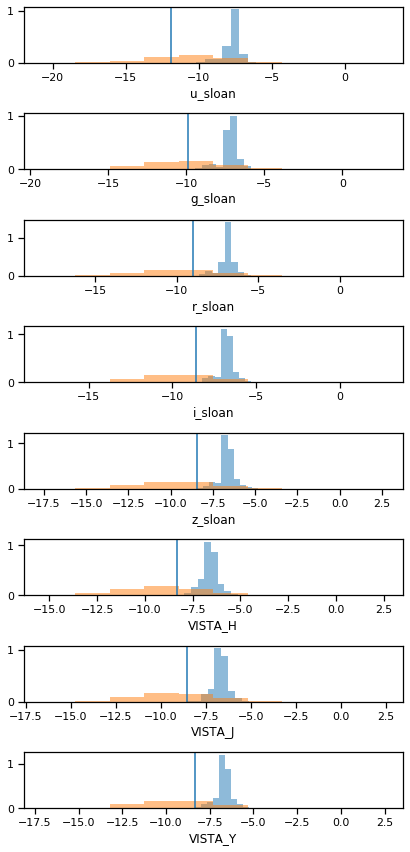

In [95]:
alpha = 0.5
fig, axes = plt.subplots(nrows=len(valid_filters), figsize=(6, 12))
for band_n, band in enumerate(valid_filters):
    ax = axes[band_n]
    ax.hist(np.log10(all_photometry[:, band_n]), alpha=alpha, density=True)
    ax.hist(np.log10(simulated_y[:, band_n]), alpha=alpha, density=True)
    ax.axvline(np.log10(all_photometry[:, band_n]).min())
    ax.set_xlabel(band.bandpass_file)
fig.tight_layout()

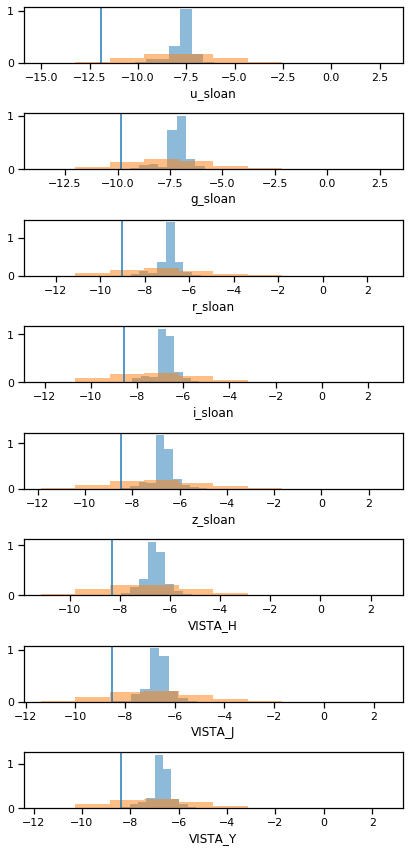

In [98]:
alpha = 0.5
low_z_y = simulated_y[theta[:, 0] < .5]
fig, axes = plt.subplots(nrows=len(valid_filters), figsize=(6, 12))
for band_n, band in enumerate(valid_filters):
    ax = axes[band_n]
    ax.hist(np.log10(all_photometry[:, band_n]), alpha=alpha, density=True)
    ax.hist(np.log10(low_z_y[:, band_n]), alpha=alpha, density=True)
    ax.axvline(np.log10(all_photometry[:, band_n]).min())
    ax.set_xlabel(band.bandpass_file)
fig.tight_layout()

In [ ]:
Euclid selection function: YJH should all be > 24.0 (lets look at missing bands later)

In [99]:
10 ** (-0.4 * 24)

2.5118864315095717e-10

Not reasonable at all! What parameters control magnitude?

In [74]:
simulated_y.shape

(600000, 8)

In [75]:
norm_theta.shape

(600000, 9)

In [90]:
param_names = ['Redshift', 'Stellar Mass', 'Dust', 'Age', 'Tau', 'AGN Disk Scale', 'AGN E(B-V)', 'AGN Torus Scale', 'AGN Torus Incl.']
assert norm_theta.shape[1] == len(param_names)

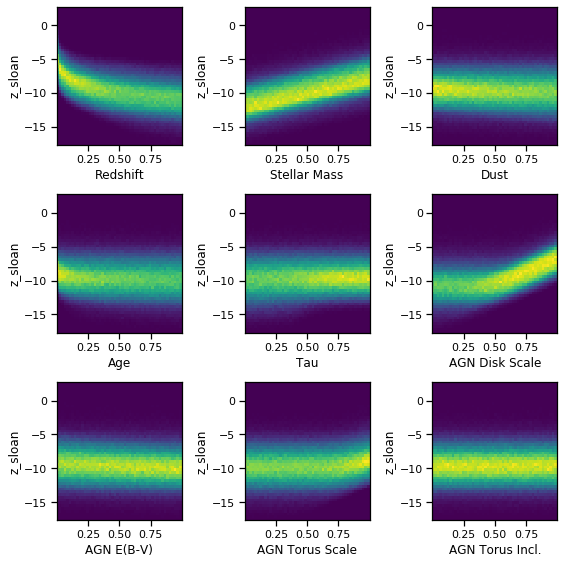

In [94]:
alpha = 0.5
n_params = norm_theta.shape[1]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
all_axes = [ax for row in axes for ax in row]
band_n = 4
for theta_n in range(n_params):
    ax = all_axes[theta_n]
    _ = ax.hist2d(norm_theta[:, theta_n], np.log10(simulated_y[:, band_n]), bins=(50, 50))
    ax.set_ylabel(valid_filters[band_n].bandpass_file)
    ax.set_xlabel(param_names[theta_n])
fig.tight_layout()

In [68]:
simulated_y_list[0].shape, simulated_y.shape

((100000, 8), (100000, 8))

### Find best matching cube galaxies

In [50]:
best_thetas = np.zeros((n_galaxies, output_dim))
best_norm_theta = np.zeros((n_galaxies, output_dim))
for n, photometry in tqdm(enumerate(all_photometry), total=n_galaxies):
    error = np.sum((photometry - simulated_y) ** 2, axis=1)
    best_params_index = np.argmin(error) # equivalent to an MLE in discrete space
    best_thetas[n] = theta[best_params_index]
    best_norm_theta[n] = norm_theta[best_params_index]

In [51]:
best_thetas

array([[2.20235139e+00, 1.64507307e+11, 1.43434796e+00, ...,
        9.94604510e-02, 1.84594110e-05, 3.13592798e+01],
       [2.39274217e+00, 2.28072317e+11, 1.58623544e+00, ...,
        1.98776382e-01, 4.38428100e-05, 8.50101466e+01],
       [2.02163263e+00, 4.87907544e+11, 1.56349189e+00, ...,
        3.75446820e-01, 1.87389985e+00, 1.09280164e+01],
       ...,
       [2.11075926e+00, 2.06290096e+10, 1.23913311e+00, ...,
        3.28258176e-01, 1.18697235e+01, 6.90068387e+00],
       [2.03503880e+00, 8.76702881e+11, 8.42977997e-01, ...,
        2.85131183e-01, 1.47365223e-06, 2.58307233e+01],
       [2.22184856e+00, 7.32533146e+11, 6.59018305e-01, ...,
        2.45557431e-01, 9.93488955e-06, 6.56813740e+01]])

<Figure size 432x288 with 0 Axes>

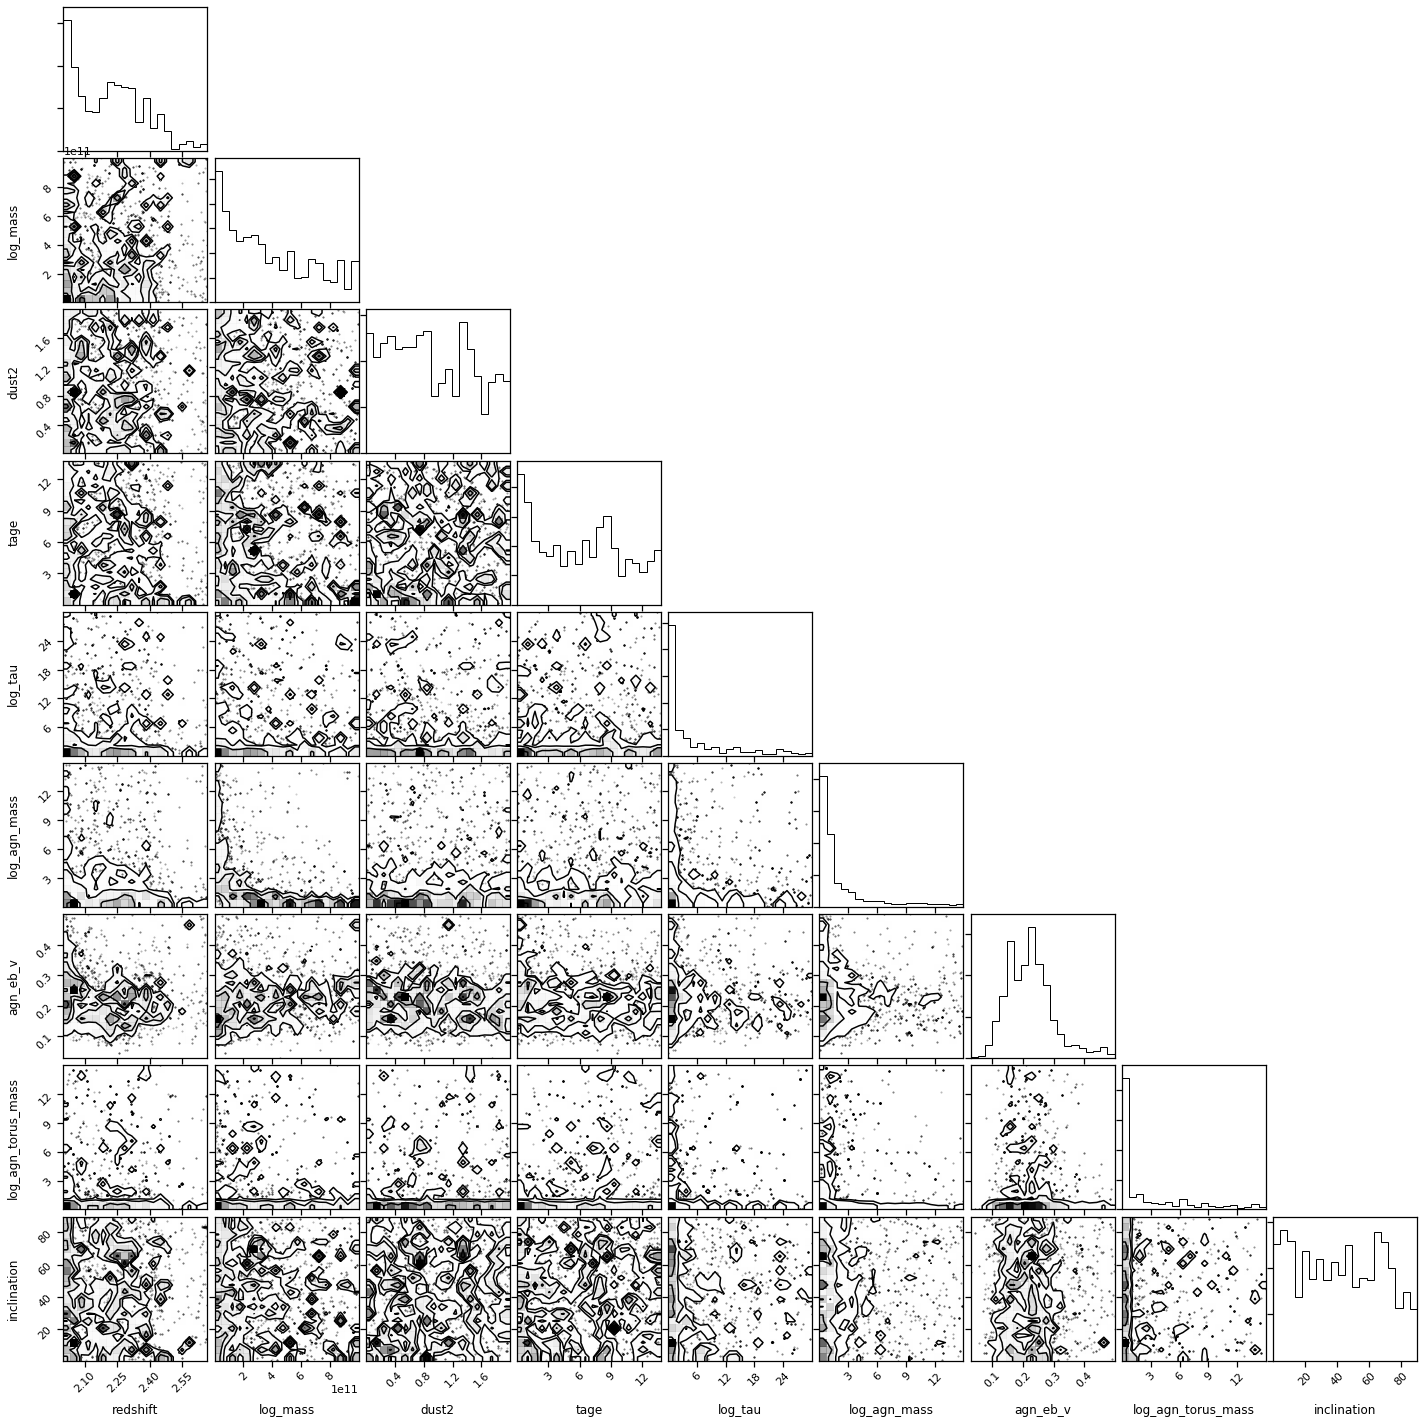

In [52]:
best_thetas_logged = best_thetas.copy()
for param_n, param in enumerate(param_names):
    if 'log' in param:
        best_thetas_logged[:, param_n] = np.log10(best_thetas[:, param_n])

plt.figure()
_ = corner.corner(best_thetas, labels=param_names)
plt.savefig(f'best_theta_{spectro_class}_{n_galaxies}.pdf')

<Figure size 432x288 with 0 Axes>

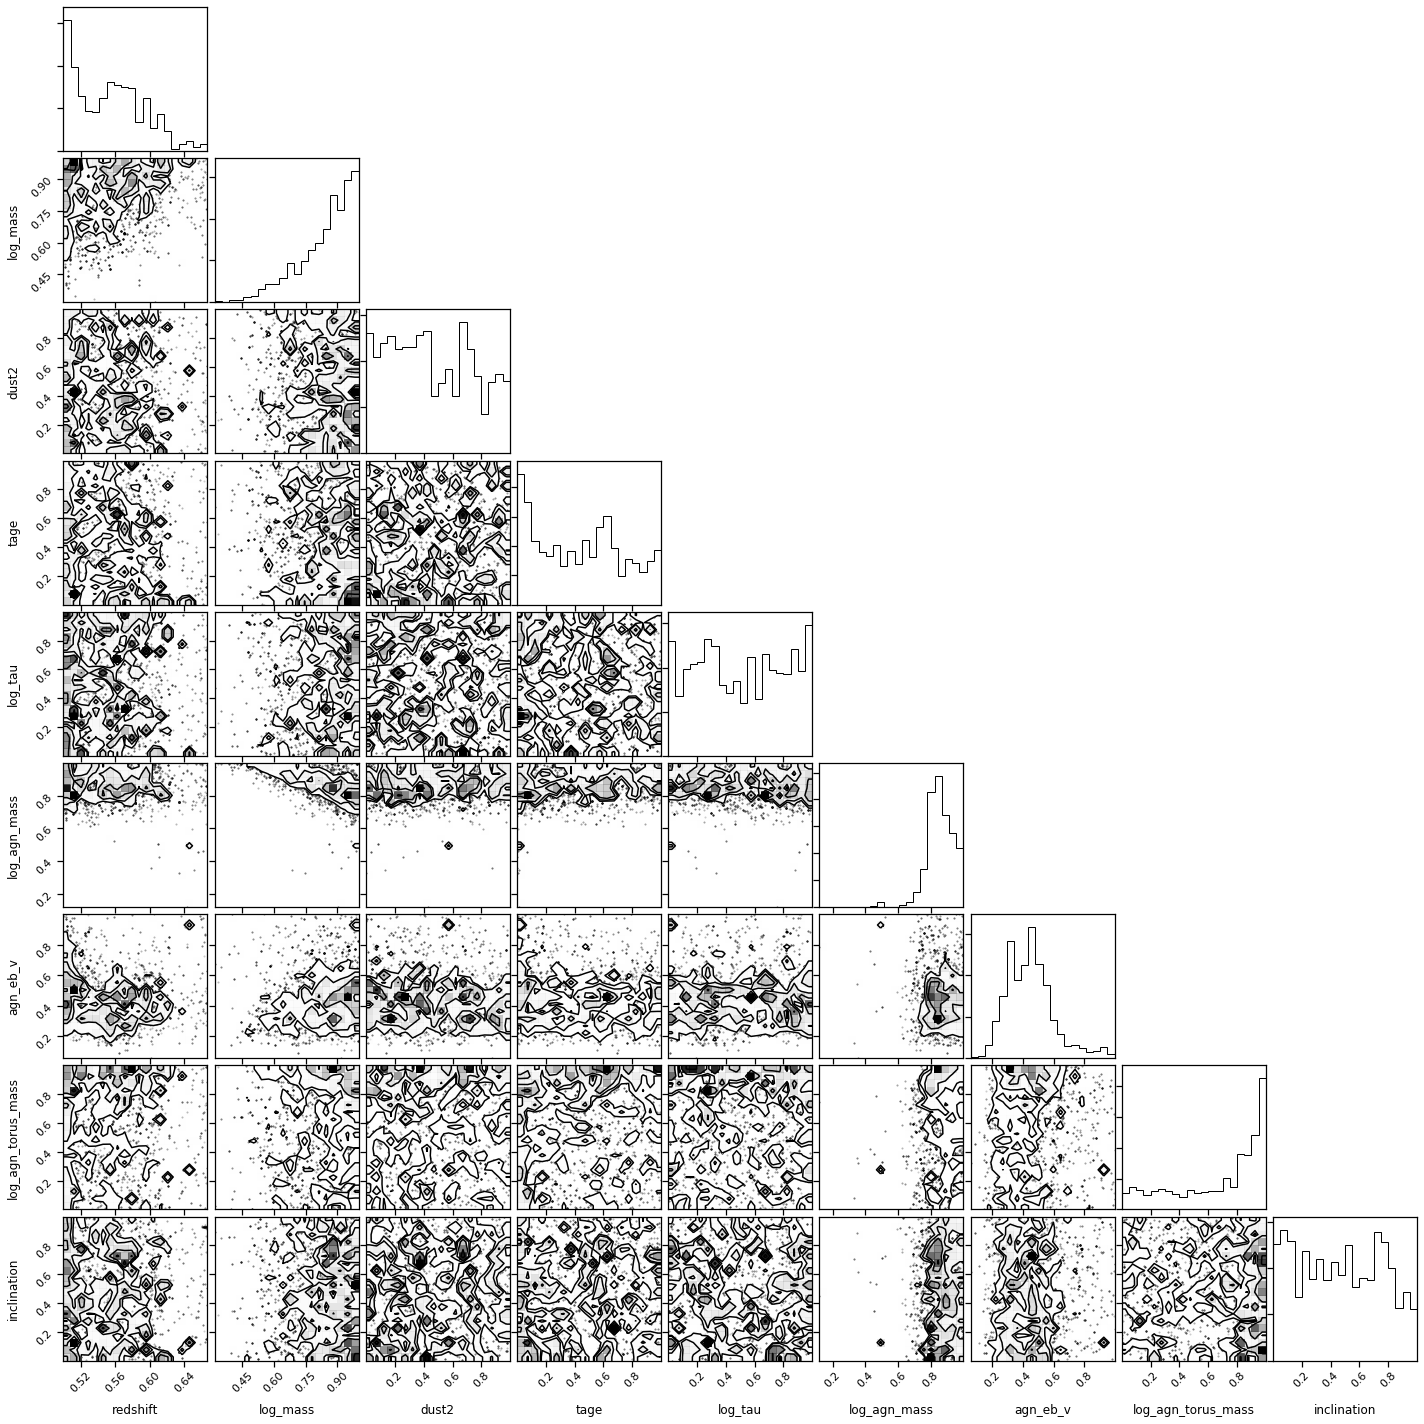

In [53]:

plt.figure()
_ = corner.corner(best_norm_theta, labels=param_names)
plt.savefig(f'best_norm_theta_{spectro_class}_{n_galaxies}.pdf')